# AGN light curve Pipeline
This code is a pipeline to generate simulated AGN light curve based on Kelly 2009.


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
from matplotlib.ticker import ScalarFormatter
from scipy.integrate import quad, dblquad
from tqdm import tqdm
import psi
from astroML.time_series import generate_power_law
from astroML.fourier import PSD_continuous

# Constants, try to keep them in SI units
G = 6.674e-11  # Universal gravitational constant (m^3 kg^-1 s^-2)
c     = 2.9979e8 # Speed of light
M_sol   = 1.989e30 # Solar mass in kg
ld    = 2.59e13 # Light day in m
sigma = 5.67e-8 # Stefan-Boltzmann constant
h    = 6.626e-34 # Planck constant
k   = 1.38e-23 # Boltzmann constant

## Observational Wavelengths

In [36]:
wavref = [3650,4640,6580,8060,9000,10200]
deredshift_wav05 = [2433, 3093, 4387, 5373, 6000, 6800]
deredshift_wav1 = [1825, 2320, 3290, 4030, 4500, 5100]
deredshift_wav2 = [1216, 1546, 2193, 2686, 3000, 3400]

## Damped Random Walk
Here are a set of functions used to generate the DRW light curve. The generate_DRW function requires the relaxation time and the standard deviation of the light curve at short time scale. The calculation for these two values requires the mass of the SMBH and luminosity of the AGN. The luminosity is calulated as a fraction of the Eddington luminosity.


In [10]:
def relaxation_time(M, L, lam = 1):
    """
    Calculate the relaxation time of an AGN using the relation from Kelly et al. 2009.
    Parameters
    ----------
    M (float): Black hole mass in kg
    L (float): Luminosity_lam in erg/s*m
    lam (float): Wavelength; default=1
    """
    M=M/M_sol
    tau_relax = 80.4*((lam*L/(10**45))**(-0.42)) * ((M/10**8)**1.03)
    
    ### Need correcting
    tau_relax_error = tau_relax - (80.4+66.9)*(lam*L/(10**45))**(-0.42+0.28) * (M/10**8)**(1.03+0.38)
    return tau_relax, tau_relax_error    

def drw_sigma(M, L, lam = 1):
    """
    Calculate the long-term variation amplitude of an AGN using the relation from Kelly et al. 2009.
    Parameters
    ----------
    M (float): Black hole mass in Kg
    L (float): Luminosity_lam in erg/s*m
    lam (float): Wavelength; default=1
    """
    M=M/M_sol
    log_sigma2 = -3.83-0.09*np.log(lam*L/10**45) * -0.25*np.log(M/10**8)
    sigma = np.sqrt(10**log_sigma2)

    ### Need correcting
    sigma_error = sigma - (0.18+0.11)*(lam*L/(10**45))**(0.18-0.09) * (M/10**8)**(0.18+0.09)
    return sigma, sigma_error

def eddington_acc(M, effi = 0.1):
    """
    Calculate the Eddington accretion rate of an AGN.
    Parameters
    ----------
    M (float): Black hole mass in kg
    effi (float): Eddington efficiency; default=0.1
    """
    M_p = 1.6726219e-27 # Proton mass in kg
    t_cross_sec = 6.6524587e-29 # Thomson cross section in m^2
    M_dot = 4*np.pi*G*M*M_p/(effi*c*t_cross_sec) # Eddington accretion rate in kg/s
    return M_dot

def generate_DRW(t_rest,mean_flux=0 ,tau=200,z=0,b=0,sigma=0.03,seed=0):
    """
    Simulates an AGN light curve using the Damped Random Walk (DRW) model (Kelly 2009).

    Parameters
    ----------
    t_rest (array_like): rest-frame time (sorted).  
    mean_flux (float): mean flux; default=10
    tau (float): relaxation time
    z (float): redshift
    mean_vari (float): mean light curve variation; default=0
    b (float): mean variation amplitude; default=0
    sigma (float): long-term variation amplitude; default=1
    seed (int): random seed for np.random

    Returns
    -------
    x (ndarray): Flux values at each time in t_rest
    """
    np.random.seed(seed)
    mean_vari = b * tau
    variance = sigma * np.sqrt(tau / 2)

    N = len(t_rest)

    t_obs = t_rest * (1 + z) / tau

    x = np.zeros(N)
    x[0] = np.random.normal(mean_vari, variance)
    epsilon = np.random.normal(0, 1, N) # White noise
    #dX(t) = -X(t) * dt + sigma * sqrt(tau) * e(t) * sqrt(dt) + b * tau * dt
    #Xmean = b * tau
    #SFinf = sigma * sqrt(tau / 2)
    
    for i in range(1, N):
        dt = t_obs[i] - t_obs[i - 1]
        x[i] = (x[i - 1] - dt * (x[i - 1] - mean_vari) 
                + sigma * np.sqrt(tau) * epsilon[i] * np.sqrt(dt)
                +b * tau * dt)

    x = x + mean_flux
    t_obs = t_rest * (1 + z)
    return x,t_obs

### Fiducial AGN
We will use a fiducial AGN with mass of 1e8.5 solar mass and 10% Eddington Lumonosity at z=0.5, 1, and, 2.

In [11]:
# Time points 
days = np.arange(0.0,10 * 365,1) # 1 day sampling for 10 years

M = 10**8.5 * M_sol # Black hole mass in kg
M_dot = 1*M_sol/(365*24*3600) # kg per second
M_dot_edd = eddington_acc(M)*0.1
L = (0.1 * M_dot_edd * c**2) * 10**7 # erg/s

DRW_sigma = drw_sigma(10**8,L)[0]
tau_relax = relaxation_time(M,L)[0]

print('1 M_sol per year [Kg/s]:',f'{M_dot:.3e}'
      ,'\n10% Eddington Accretion [kg/s]: ' , f'{eddington_acc(M)*0.1:.3e}')
print('Luminosity [erg/s]: ',f'{L:.3e}')
print('Relaxation Time [days]: ',round(tau_relax,4))
print('sigma: ',round(DRW_sigma,4))


1 M_sol per year [Kg/s]: 6.307e+22 
10% Eddington Accretion [kg/s]:  4.424e+22
Luminosity [erg/s]:  3.976e+45
Relaxation Time [days]:  147.3945
sigma:  0.001


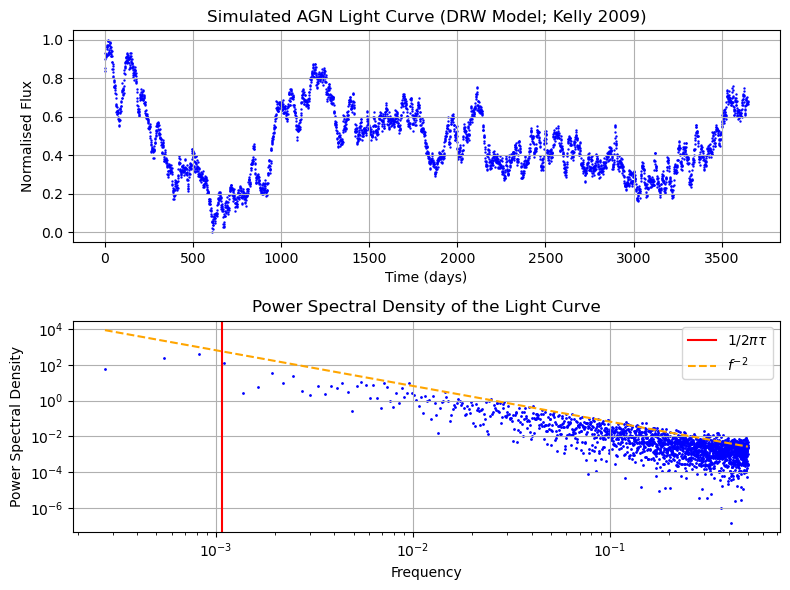

In [20]:
light_curve, t_obs = generate_DRW(days,tau = tau_relax,sigma=DRW_sigma, z=0.0, seed=0)

def normalise(light_curve_data):
    return (light_curve_data - np.min(light_curve_data)) / (np.max(light_curve_data) - np.min(light_curve_data))

normalised_lc = normalise(light_curve)
# Compute the power spectral density
f, PSD = PSD_continuous(days, light_curve)
alpha = PSD[-1] / f[-1]**-2

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

# Plot the simulated light curve
axs[0].scatter(days, normalised_lc, s=0.5, color='blue')
axs[0].set_xlabel('Time (days)')
axs[0].set_ylabel('Normalised Flux')
axs[0].set_title('Simulated AGN Light Curve (DRW Model; Kelly 2009)')
axs[0].grid(True)

# Plot the power spectral density
axs[1].scatter(f, PSD, s=1, color='blue')
axs[1].axvline(1/(2*np.pi*tau_relax), color='red', label=r'1/2$\pi\tau$')
# Plot a line proportional to frequency^-2 for comparison
axs[1].loglog(f[1:], alpha*(f[1:]**-2), label=r'$f^{-2}$', linestyle='--', color='orange')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Power Spectral Density')
axs[1].set_title('Power Spectral Density of the Light Curve')
axs[1].grid(True)
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

## Temperature Profile & Disc Continuum Emission
In order to calculate the measured flux, we need to know the continuum emission from the disc. We assume the disc to be geometrically thin and optically thick. The continuum spectrum is given by the sum of the blackbody spectrum at each radius of the disc.

In [27]:
def temp_r(radius, M, M_dot, hx, albedo, efficiency, r_in):
    """
    Calculate the temperature of an accretion disk at a given radius.

    Parameters
    ----------
    radius (float): radius in light days
    M (float): mass of the black hole in solar masses
    M_dot (float): accretion rate in solar masses per year
    hx (float): height of the disk at the radius in gravitational radii
    albedo (float): albedo of the disk
    efficiency (float): efficiency parameter
    """
    M_sol   = 1.989e30  # Solar mass in kg
    ld    = 2.59e13 # Light day in m

    rs    = 2*G*M/c**2 # Schwarzschild radius in m
    r_in = r_in*rs # Inner radius of the disk in m
    hx    = hx*rs # Height of lamp in m
    Lb    = efficiency*M_dot*c**2 # Luminosity of the disk in W

    temp_vis = (3*G*M*M_dot/(8*np.pi*sigma*radius**3)*(1-np.sqrt(r_in/radius)))**(1/4)
    temp_irr = ((1 - albedo)*(hx*Lb)/(4*np.pi*sigma*(np.sqrt((radius**2)+(hx**2)))**3))**(1/4)
    temp_tot = ((3*G*M*M_dot/(8*np.pi*sigma*radius**3)*(1-np.sqrt(r_in/radius))) 
             + ((1 - albedo)*(hx*Lb)/(4*np.pi*sigma*(np.sqrt(((radius)**2)+(hx**2)))**3)) )**(1/4)
    return temp_tot, temp_vis, temp_irr


def weins_law(T): #angstrom
    return  0.0029* 1e10/T 

def grav_radius(M): # Mass in Kg
    return 2*G*M/c**2

### Starkey 2016 Fig 1, R_in = Rs
Here we reproduced Starkey 2016 plot for 1e8 M_sol and 1M_dot AGN with R_in = Rs.

Gravitational Radius [m]:  295404221161.55774


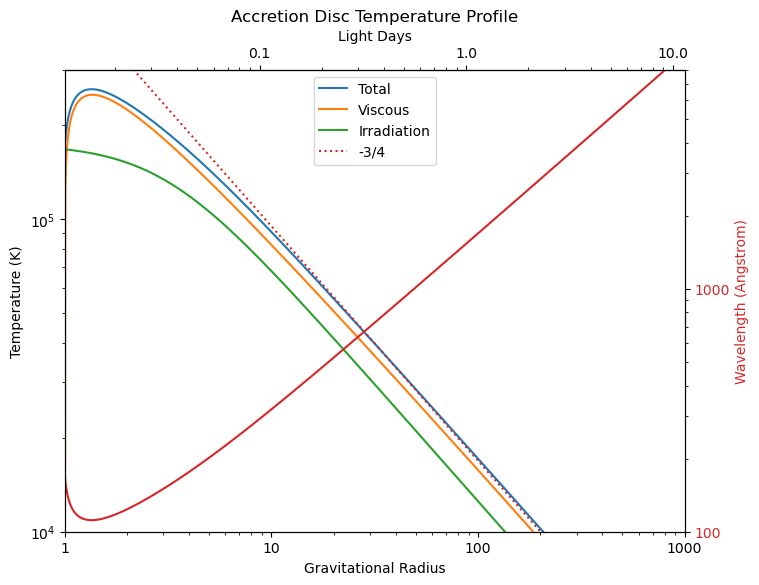

In [28]:
M_sol   = 1.989e30  # Solar mass in kg
ld    = 2.59e13 # Light day in m

M=10**8 # Solar masses
M = M*M_sol # Black hole mass in kg

M_dot= 1 # Solar masses per year
M_dot = M_dot*M_sol/(365*24*3600) # Accretion rate in kg/s 

hx= 3 # Gravitational radii
albedo= 0.1 # Albedo
efficiency= 0.1 # accretion efficiency
rs    = grav_radius(M) # Schwarzschild radius in m
r_in = 1 # Inner radius of the disk in gravitational radii

def ld2rg(x):
    return (x*2.59e13)/(rs)
def rg2ld(x):
    return (x*rs)/2.59e13

print('Gravitational Radius [m]: ',rs)
radii = np.logspace(np.log10(rs+1), np.log10(rs*1000), 1000) #m
temp_prof, temp_vis, temp_irr = temp_r((radii), (M),(M_dot),hx,albedo,efficiency,r_in)

emitting_lambda = weins_law(temp_prof)

# Create subplots
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
axs.plot(radii/rs, temp_prof, label='Total')
axs.plot(radii/rs, temp_vis, label='Viscous')
axs.plot(radii/rs, temp_irr, label='Irradiation')
axs.plot(radii/rs, (3e0*(radii[999]/rs)/(radii[999]/rs)**(-3/4))*(radii/rs)**(-3/4)
         , label='-3/4', linestyle=':')
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlabel('Gravitational Radius')
axs.set_ylabel('Temperature (K)')
axs.set_title('Accretion Disc Temperature Profile')
axs.xaxis.set_major_formatter(ScalarFormatter())
axs.set_ylim(1e4, 3e5)
axs.set_xlim(1, 1000)
axs.legend(loc='upper center')
#axs.axvline(rg2ld(3))
#minor_locator = ticker.MultipleLocator(5e3)  # Set minor ticks every 0.5 units
#axs.yaxis.set_major_locator(minor_locator)
ax2 = axs.twinx() 
 
color = 'tab:red'
ax2.set_ylabel('Wavelength (Angstrom)',color = color) 
ax2.plot(radii/rs, emitting_lambda,color = color) 
ax2.tick_params(axis ='y',labelcolor  = color) 
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(ScalarFormatter())
ax2.set_ylim(100,8000)
#
secax = axs.secondary_xaxis('top', functions=(rg2ld,ld2rg ))
secax.set_xlabel('Light Days')
secax.set_xlim(1,1000)
secax.xaxis.set_major_formatter(ScalarFormatter())

### Fiducial AGN with R_in = 3 Rs

Temperature at R0 [k]:  21913.960554005356
Gravitational Radius [m]:  934150169298.6335
Light Days [m]:  25900000000000.0
27.725734952706695
52887 58560 66769 71510 74085


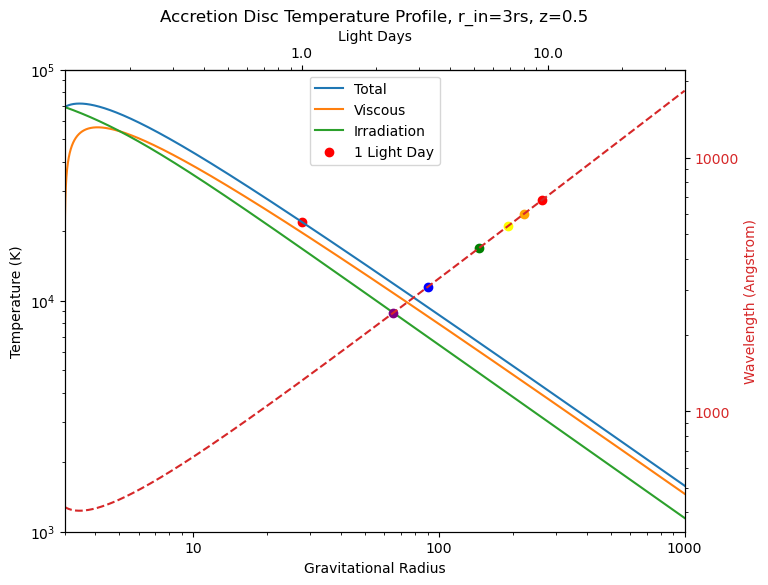

In [41]:
# Time points 
days = np.arange(0.0,10 * 365,1) # 1 day sampling for 10 years

M = 10**8.5 * M_sol # Black hole mass in kg
M_dot_edd = eddington_acc(M)*0.1 # kg per second
L = (0.1 * M_dot_edd * c**2) * 10**7 # erg/s

DRW_sigma = drw_sigma(10**8,L)[0]
tau_relax = relaxation_time(M,L)[0]

hx= 3 # Gravitational radii
albedo= 0.1 # Albedo
efficiency= 0.1 # accretion efficiency
rs    = 2*G*M/c**2 # Schwarzschild radius in m
r_in = 3 # Inner radius of the disk in gravitational radii

def ld2rg(x):
    return (x*2.59e13)/(rs)
def rg2ld(x):
    return (x*rs)/2.59e13

radii = np.logspace(np.log10(r_in*rs+1), np.log10(rs*1000), 100000) #m
temp_prof, temp_vis, temp_irr = temp_r((radii), (M),(M_dot_edd),hx,albedo,efficiency,r_in)

# Temperature at R0
temp_r0_index = np.where(radii >= ld)[0]
temp_r0 = temp_prof[temp_r0_index[0]]
print('Temperature at R0 [k]: ',temp_r0)
print('Gravitational Radius [m]: ',rs)
print('Light Days [m]: ',ld)
print(ld/rs)
emitting_lambda = weins_law(temp_prof)


# Rest Frame Wavelength
wav_index1 = np.where(emitting_lambda >= deredshift_wav05[0])[0]
wav_index2 = np.where(emitting_lambda >= deredshift_wav05[1])[0]
wav_index3 = np.where(emitting_lambda >= deredshift_wav05[2])[0]
wav_index4 = np.where(emitting_lambda >= deredshift_wav05[3])[0]
wav_index5 = np.where(emitting_lambda >= deredshift_wav05[4])[0]
wav_index6 = np.where(emitting_lambda >= deredshift_wav05[5])[0]
print(wav_index1[0],wav_index2[0],wav_index3[0],wav_index4[0],wav_index5[0])   



# Create subplots
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
axs.plot(radii/rs, temp_prof, label='Total')
axs.plot(radii/rs, temp_vis, label='Viscous')
axs.plot(radii/rs, temp_irr, label='Irradiation')
axs.scatter(radii[temp_r0_index[0]]/rs, temp_r0, label='1 Light Day', color='red')
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlabel('Gravitational Radius')
axs.set_ylabel('Temperature (K)')
axs.set_title('Accretion Disc Temperature Profile, r_in=3rs, z=0.5')
axs.xaxis.set_major_formatter(ScalarFormatter())
axs.set_ylim(1e3, 1e5)
axs.set_xlim(r_in, 1000)
axs.legend(loc='upper center')
#axs.axvline(rg2ld(3))
#minor_locator = ticker.MultipleLocator(5e3)  # Set minor ticks every 0.5 units
#axs.yaxis.set_major_locator(minor_locator)
ax2 = axs.twinx() 
 
color = 'tab:red'
ax2.set_ylabel('Wavelength (Angstrom)',color = color) 
ax2.plot(radii/rs, emitting_lambda,color = color, linestyle='--') 
ax2.scatter(radii[wav_index1[0]]/rs, emitting_lambda[wav_index1[0]],color = 'purple')
ax2.scatter(radii[wav_index2[0]]/rs, emitting_lambda[wav_index2[0]],color = 'blue')
ax2.scatter(radii[wav_index3[0]]/rs, emitting_lambda[wav_index3[0]],color = 'green')
ax2.scatter(radii[wav_index4[0]]/rs, emitting_lambda[wav_index4[0]],color = 'yellow')
ax2.scatter(radii[wav_index5[0]]/rs, emitting_lambda[wav_index5[0]],color = 'orange')
ax2.scatter(radii[wav_index6[0]]/rs, emitting_lambda[wav_index6[0]],color = 'red')
ax2.tick_params(axis ='y',labelcolor  = color) 
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(ScalarFormatter())
#ax2.set_ylim(100,8000)

#
secax = axs.secondary_xaxis('top', functions=(rg2ld,ld2rg ))
secax.set_xlabel('Light Days')
secax.set_xlim(1,1000)
secax.xaxis.set_major_formatter(ScalarFormatter())


### Continuum Spectrum

In [65]:
inclination = 0
# Mpc at z=.05
mpc = 1908.7 
def Mpc2Cm(d):
    return d*3.086e24
distance = Mpc2Cm(mpc) # Mpc to cm
erg = 1e7 # J to erg

# Define the Planck function, F_nu
def planck_function(freq, temp):
    # Computes black body intensity (J/m^2/s/Hz/sr) at given temperature and frequency.

    c1 = (2 * k**3)/(c**2 * h**2) # (2kb^3)/(c^2h^2)
    c2 = h / k # h/kb
    
    x = c2 * freq / temp

    if (x < 1e-5): # Rayleigh-Jeans tail
        Planck = c1*(x**2)*(temp**3)
    else:
        Planck = c1*(x**3)*(temp**3) / (np.expm1(x))
    return Planck

# Define the integrand for the emitted spectrum
def integrand(r, lam):
    temp_prof, _, _ = temp_r(r, M, M_dot, hx, albedo, efficiency, r_in)
    if np.isnan(temp_prof):
        return 0
    freq = c / lam
    return planck_function(freq, temp_prof) * 2 * np.pi * r * np.cos(inclination) / distance**2

# Define the wavelength range (in meters)
wavelengths = np.linspace((1e-8), (1e-3), 100000)  # Wavelength in meters
#wavelengths = np.logspace(np.log10(1e-8), np.log10(1e-5), 10000)  # Wavelength in meters
# Define the radius range (in rs)
r_min = rs*3 #m
r_max = (rs*1000) #m
print(r_min/ld, r_max/ld)

# Compute the emitted spectrum by integrating over the radius range
emitted_spectrum = []
for lam in wavelengths:
    spectrum, _ = quad(integrand, r_min, r_max, args=(lam,),limit=50)
    #spectrum = spectrum*()
    emitted_spectrum.append(spectrum)

# Convert the emitted spectrum to a numpy array
emitted_spectrum = np.array(emitted_spectrum)

0.10820272231258303 36.06757410419434


C:\Users\nikko\AppData\Local\Temp\ipykernel_7284\1984142984.py:21: RuntimeWarning: overflow encountered in expm1
  Planck = c1*(x**3)*(temp**3) / (np.expm1(x))


Here we plot the continuum spectrum in the rest frame with the centre of each bandpass marked on the spectrum.

3650 6.783326592720367e-34
4640 6.540222871518518e-34
6580 6.087854991868099e-34
8060 5.813634140957003e-34
9000 5.6437393211652165e-34
10200 5.4690802756261515e-34


Text(0.5, 1.0, 'Background spectrum')

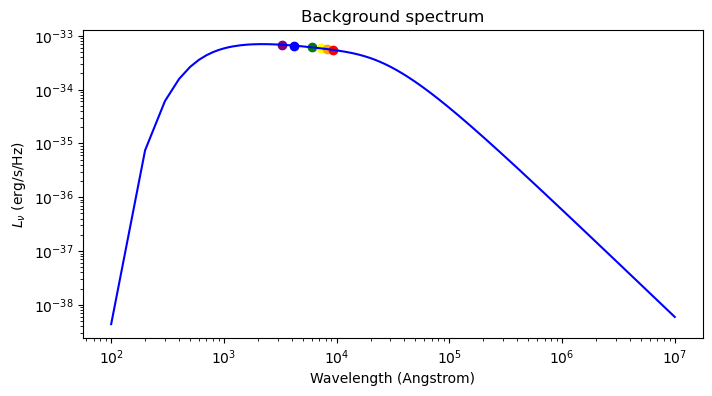

In [ ]:
background_L = []
background_index = []
for wav in wavref:
    index = np.where((wavelengths >= 0.9*(wav*1e-10)) & (wavelengths <= 1.1*(wav*1e-10)))[0]
    background_L.append(emitted_spectrum[index][0])
    background_index.append(index[0])
    #print(wav, emitted_spectrum[index][0])
# Create subplots
rayleigh_jean_tail = 6000
weins_tail = 200
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.plot(wavelengths * 1e+10, emitted_spectrum, color='blue')

''' Uncomment to verify the Rayleigh-Jeans and Wien's tail slope
axs.scatter(wavelengths[weins_tail] * 1e+10, emitted_spectrum[weins_tail], color='red')
axs.scatter(wavelengths[rayleigh_jean_tail] * 1e+10, emitted_spectrum[rayleigh_jean_tail], color='red')
alpha1 = (emitted_spectrum[weins_tail])/(wavelengths[weins_tail]**-(1/3))#(wavelengths[100])/(emitted_spectrum[100]) 
alpha2 = (emitted_spectrum[rayleigh_jean_tail])/(wavelengths[rayleigh_jean_tail])**(-2)
axs.plot(wavelengths * 1e+10, alpha1*((wavelengths)**(-1/3)), color='red', linestyle='--')
axs.plot(wavelengths[4000:] * 1e+10, alpha2*(wavelengths[4000:])**(-2), color='red', linestyle=':')
'''

axs.scatter(wavelengths[background_index[0]]*1e+10, background_L[0], color='purple')
axs.scatter(wavelengths[background_index[1]]*1e+10, background_L[1], color='blue')
axs.scatter(wavelengths[background_index[2]]*1e+10, background_L[2], color='green')
axs.scatter(wavelengths[background_index[3]]*1e+10, background_L[3], color='yellow')
axs.scatter(wavelengths[background_index[4]]*1e+10, background_L[4], color='orange')
axs.scatter(wavelengths[background_index[5]]*1e+10, background_L[5], color='red')
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlabel('Wavelength (Angstrom)')
axs.set_ylabel(r'$L_\nu$ (erg/s/Hz)')
axs.set_title('Rest Frame Background spectrum')

[3600.] 6.964992244499845e-34
[3600. 4500.] 6.857627845087088e-34
[3600. 4500. 6300.] 6.540222871518518e-34
[3600. 4500. 6300. 7800.] 6.278643730854869e-34
[3600. 4500. 6300. 7800. 8550.] 6.157353432601691e-34
[3600. 4500. 6300. 7800. 8550. 9750.] 5.97827726493952e-34
[4950.] 6.783326592720367e-34
[4950. 6300.] 6.540222871518518e-34
[4950. 6300. 9000.] 6.087854991868099e-34
[ 4950.  6300.  9000. 10950.] 5.813634140957003e-34
[ 4950.  6300.  9000. 10950. 12300.] 5.6437393211652165e-34
[ 4950.  6300.  9000. 10950. 12300. 13800.] 5.4690802756261515e-34


Text(0.5, 1.0, 'Rest Frame Background spectrum')

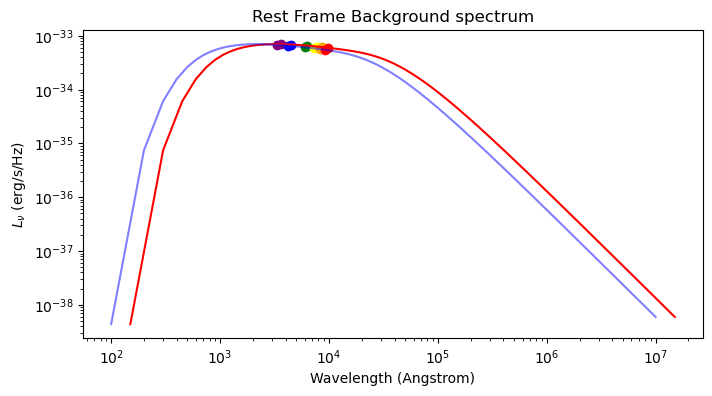

In [87]:
redshifted_wavelength = wavelengths * (1 + 0.5)
background_L = []
background_index = []
for wav in wavref:
    index = np.where((redshifted_wavelength >= 0.95*(wav*1e-10)) & (redshifted_wavelength <= 1.01*(wav*1e-10)))[0]
    background_L.append(emitted_spectrum[index][0])
    background_index.append(index[0])
    print(redshifted_wavelength[background_index]*1e+10, emitted_spectrum[index][0])

# Create subplots
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.plot(redshifted_wavelength * 1e+10, emitted_spectrum, color='red')


axs.scatter(redshifted_wavelength[background_index[0]]*1e+10, background_L[0], color='purple')
axs.scatter(redshifted_wavelength[background_index[1]]*1e+10, background_L[1], color='blue')
axs.scatter(redshifted_wavelength[background_index[2]]*1e+10, background_L[2], color='green')
axs.scatter(redshifted_wavelength[background_index[3]]*1e+10, background_L[3], color='yellow')
axs.scatter(redshifted_wavelength[background_index[4]]*1e+10, background_L[4], color='orange')
axs.scatter(redshifted_wavelength[background_index[5]]*1e+10, background_L[5], color='red')

#""" Rest Frame
background_L = []
background_index = []
for wav in wavref:
    index = np.where((wavelengths >= 0.9*(wav*1e-10)) & (wavelengths <= 1.1*(wav*1e-10)))[0]
    background_L.append(emitted_spectrum[index][0])
    background_index.append(index[0])
    print(redshifted_wavelength[background_index]*1e+10, emitted_spectrum[index][0])
axs.plot(wavelengths * 1e+10, emitted_spectrum,alpha=0.5, color='blue')
axs.scatter(wavelengths[background_index[0]]*1e+10, background_L[0], color='purple')
axs.scatter(wavelengths[background_index[1]]*1e+10, background_L[1], color='blue')
axs.scatter(wavelengths[background_index[2]]*1e+10, background_L[2], color='green')
axs.scatter(wavelengths[background_index[3]]*1e+10, background_L[3], color='yellow')
axs.scatter(wavelengths[background_index[4]]*1e+10, background_L[4], color='orange')
axs.scatter(wavelengths[background_index[5]]*1e+10, background_L[5], color='red')
#"""

axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlabel('Wavelength (Angstrom)')
axs.set_ylabel(r'$L_\nu$ (erg/s/Hz)')
axs.set_title('Rest Frame Background spectrum')

